# Final evaluation of transfer learning network

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Defines imports
import ipykernel
import os
import sys
module_path = os.getcwd() + '/utilities'
sys.path.insert(0, module_path)
import pandas as pd

import torch
import numpy as np
import normflows as nf
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from scipy.spatial import distance
import yaml
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import os
import random

from scipy.spatial import distance
import scipy.stats as scis
import scipy.io as scio
from scipy.stats import gaussian_kde

import pickle 
from tqdm import tqdm

import model_functions as mfunc
from evaluation import average_2dprobs, eval_dist_reference, evaluate_error, evaluate_jsd, gen_2dprobs, get_group_metrics
from numpy import mean
from numpy import var
from math import sqrt

## Definitions

In [3]:
# defines models to evaluate
model_description = {'run_code': 'run-20240606_121520-v13l8sdq',
                    'num_mri_raw': 87,
                    'desc':'baseline'}

# Defines constants
_BASE_FOLDER = os.getcwd()
_DATASET_FOLDER = _BASE_FOLDER+'/datasets'
_RESULTS_FOLDER = _BASE_FOLDER+'/experimental_results'
_MODELS_FOLDER = _BASE_FOLDER+'/trained-models'

_REGIONS = ['genu','body','splenium']
_BATCH_SIZE = 32
dataset = 'submission_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data loading functions

In [4]:
def build_dataset(dataset_name, batch_size):
    file_name = os.path.join(_DATASET_FOLDER,f'{dataset_name}.pkl')
    with open(file_name, 'rb') as file:
        data_save = pickle.load(file)

    test_data = data_save['test']
    x_test = test_data['x_scaled']
    mouse_num_test = test_data['mouse_num'].flatten()
    regions_test = test_data['regions'].flatten()
    mri_gratios = test_data['mri_gratios'].flatten()
    num_channels = x_test.shape[1]
    
    return x_test, mouse_num_test, regions_test, mri_gratios, num_channels

def build_network(num_channels, context_size, K, num_blocks, hidden_units, dropout, num_mri_raw):
    model = mfunc.CombinedMLP_withMaps_auxTasks(num_channels=num_channels, num_mri_raw=num_mri_raw, 
                            context_size=context_size, K = K, 
                            hidden_units = hidden_units, num_blocks = num_blocks, 
                            dropout_rate = dropout)
    return model




## Plots 

K:2
# Blocks:2
# Hidden units:96
# Context size:8


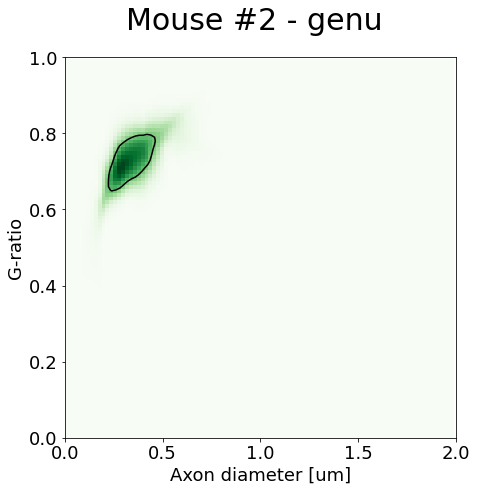

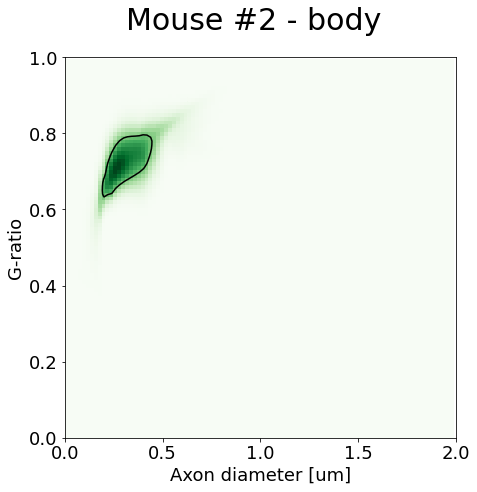

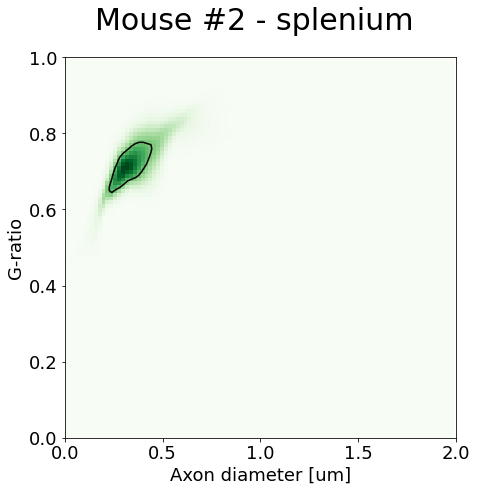

In [5]:
run_name = model_description['run_code']
dataset_exp = 'submission_dataset'
config_path = f'{_MODELS_FOLDER}/{run_name}/files/config.yaml'
weights_path = f'{_MODELS_FOLDER}/{run_name}/files/transferred-model.pth'

# Only one mouse data is provided in this dataset
mouse_num_eval = [2,2,2]
mouse_region_eval = [0,1,2]

with open(config_path, "r") as stream:
    try:
        config_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

sel_K = config_info['K']['value']
sel_num_blocks = config_info['num_blocks']['value']
sel_hidden_units = config_info['hidden_units']['value']
sel_context_size = config_info['context_size']['value']
print(f'K:{sel_K}')
print(f'# Blocks:{sel_num_blocks}')
print(f'# Hidden units:{sel_hidden_units}')
print(f'# Context size:{sel_context_size}')
num_mri_raw = model_description['num_mri_raw']

x_test, mouse_num_test, regions_test, mri_gratios, num_channels = build_dataset(dataset_exp, 32)
all_mouse_num =  np.array(mouse_num_test)
all_regions = np.array(regions_test)

# Builds the network
model = build_network(num_channels, sel_context_size, sel_K, sel_num_blocks, sel_hidden_units, 0.0, num_mri_raw)
total_context = sel_context_size+num_channels-num_mri_raw
model.region_output = nn.Linear(total_context, 3)
model.group_output = nn.Linear(total_context, 2)
# Loads weights
model.load_state_dict(torch.load(weights_path)) 
model = model.to(device)
model.eval()

# Obtains average density functions on all voxels of ROI
all_joint_probs = gen_2dprobs(model,x_test,num_mri_raw, device)
joint_test, meanMRIGratios = average_2dprobs(all_joint_probs, mouse_num_eval,  mouse_region_eval, mouse_num_test, regions_test, mri_gratios)

file_name = os.path.join(_DATASET_FOLDER,f'{dataset_exp}.pkl')
with open(file_name, 'rb') as file:
    data_save = pickle.load(file)

test_data = data_save['test']
mri_gratio_test = test_data['mri_gratios']

x_all = x_test
delta_g = 0.01
delta_d = 0.02
bins_g = np.arange(0,1.01,delta_g)
bins_d = np.arange(0,2.02,delta_d)
curve_g = np.arange(0,1,delta_g).astype('float32')
curve_d = np.arange(0,2,delta_d).astype('float32')
bins_g_2dplot = np.arange(0,1,0.01)
bins_d_2dplot = np.arange(0,2,0.02)

distances_diameter = []
distances_gratio = []

for selected_index in range(joint_test.shape[0]):
    c_mouse_num = mouse_num_eval[selected_index]
    c_region = _REGIONS[mouse_region_eval[selected_index]]

    xx, yy = torch.meshgrid(torch.from_numpy(curve_d), torch.from_numpy(curve_g), indexing='ij')
    zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
    zz = zz.to(device)

    selected_input = torch.from_numpy(np.expand_dims(x_all[selected_index,:].astype('float32'),0)).to(device)
    selected_context = model.context_encoder(selected_input, num_mri_raw).to(device)
    rep_context = (selected_context + torch.zeros((zz.shape[0],1)).to(device))

    log_prob = model.flow_model.log_prob(zz, rep_context).to('cpu').view(*xx.shape)
    prob = torch.exp(log_prob)
    prob[torch.isnan(prob)] = 0

    # integrates to get the marginal densities
    p_g = np.sum(prob.data.numpy(),axis=0)*delta_d
    p_d = np.sum(prob.data.numpy(),axis=1)*delta_g

    # Joint probability from the network
    fig_2d, axs_2d = plt.subplots(1, 1, figsize=(7, 7))      
    im = axs_2d.pcolormesh(xx, yy, prob.data.numpy(), shading='auto', cmap='Greens')
    half_max_prob = 0.5 * np.max(prob.data.numpy())
    axs_2d.contour(xx, yy, prob.data.numpy(), levels=[half_max_prob], colors='black')
   
    axs_2d.set_xlabel('Axon diameter [um]',fontsize=18)
    axs_2d.set_ylabel('G-ratio',fontsize=18)
    axs_2d.set_xlim([0,2])
    axs_2d.set_ylim([0,1])
    axs_2d.tick_params(axis='both', labelsize=18)
    fig_2d.suptitle(f'Mouse #{c_mouse_num} - {c_region}', fontsize=30)


    plt.show()
    

    

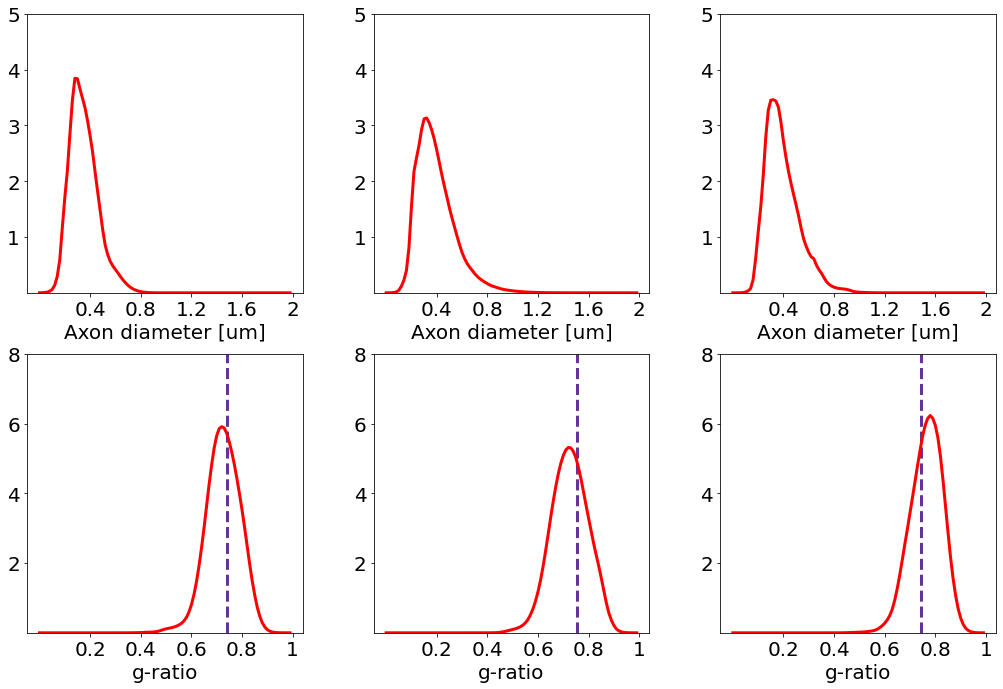

In [6]:
# Plots of marginal distributions
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.tight_layout(pad=4.0)
ax_linear = axs.flatten()
titles=['WT mouse - Genu','WT mouse - Body', 'WT mouse - Splenium','Mutant mouse - Genu','Mutant mouse - Body', 'Mutant mouse - Splenium']
x_all = x_test
df = pd.DataFrame(columns = ['Mean_GT', 'Mean_DL', 'Biophysical', 'Diff_DL','Diff_Biophysical'])
offset_axis = 3

distances_diameter = []
distances_gratio = []
for ind in range(joint_test.shape[0]):
   
    prob = joint_test[ind,:,:]
    # integrates to get the marginal densities
    p_g = np.sum(prob,axis=0)*delta_d
    p_d = np.sum(prob,axis=1)*delta_g

    # axon diameter plots
    ax_linear[ind].plot(curve_d,p_d,color='red',linewidth=3)
    ax_linear[ind].set_xlabel('Axon diameter [um]',fontsize=20)
    ax_linear[ind].set_ylim([0,5])
    ax_linear[ind].set_xticks([0.4,0.8,1.2,1.6,2])
    ax_linear[ind].set_xticklabels([0.4,0.8,1.2,1.6,2], fontsize=20)
    ax_linear[ind].set_yticks([1,2,3,4,5])
    ax_linear[ind].set_yticklabels([1,2,3,4,5], fontsize=20)
    
    # g-ratio plots
    ax_linear[ind+offset_axis].plot(curve_g,p_g,color='red',linewidth=3)
    ax_linear[ind+offset_axis].set_xlabel('g-ratio',fontsize=20)
    ax_linear[ind+offset_axis].set_ylim([0,8])
    ax_linear[ind+offset_axis].set_xticks([0.2,0.4,0.6,0.8,1])
    ax_linear[ind+offset_axis].set_xticklabels([0.2,0.4,0.6,0.8,1], fontsize=20)
    ax_linear[ind+offset_axis].set_yticks([2,4,6,8])
    ax_linear[ind+offset_axis].set_yticklabels([2,4,6,8], fontsize=20)

    mri_gratio = meanMRIGratios[ind]
    ax_linear[ind+offset_axis].vlines(x=mri_gratio, ymin=0, ymax=8, colors='rebeccapurple', ls='--', lw=3)
    

plt.show()